# Imports

In [1]:
import torch
import pandas as pd
from scipy.spatial.distance import cosine
from tqdm import tqdm
import pickle
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
training_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device=training_device
device

device(type='cuda')

In [3]:
df_train=pd.read_csv("/kaggle/input/aml-dataset/cf_train_no_noise.csv")
df_test=pd.read_csv("/kaggle/input/aml-dataset/cf_test_no_noise.csv")
encoding_map = {0: 0, 0.25: 1, 0.5: 2, 0.75: 3, 1: 4}

# Define a function to map the values to classes
def encode_to_classes(value):
    for key, val in encoding_map.items():
        if value == key:
            return val
    return None  # return None if value doesn't match any key

# Apply the function to create a new column with encoded classes
df_train['target_10_val'] = df_train['target_10_val'].apply(encode_to_classes)
df_test['target_10_val'] = df_test['target_10_val'].apply(encode_to_classes)

# Custom Dataloader

In [4]:
class CustomDataset:
    def __init__(self,dataframe,batch_size,device =training_device,shuffle=False):
        self.df=dataframe
        self.batch_size=batch_size
        self.columns_to_drop=['row_num','day','era','target_10_val','target_5_val','sigma','day_no']
        self.X = self.df.drop(self.columns_to_drop, axis=1)
        self.y=self.df['target_10_val']
        self.device=device
        self.shuffle=shuffle

    def generate_batches_with_labels(self,start_idx,end_idx):
        data=self.X.iloc[start_idx:end_idx]
        labels=self.y.iloc[start_idx:end_idx]
        dataset =  torch.utils.data.TensorDataset(torch.tensor(data.values),torch.tensor(labels.values))
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=self.batch_size, shuffle=self.shuffle)
        # data_unseen = self.X.iloc[max(0,idx-9):idx+1]
        # labels_unseen=self.y.iloc[max(0,idx-9):idx+1]
        # data_unseen,labels_unseen = torch.tensor(data_unseen.values).to(self.device),torch.tensor(labels_unseen.values).to(self.device)
        return dataloader
    
        

In [5]:
customDS_train = CustomDataset(df_train,1024,shuffle = False)
customDS_test = CustomDataset(df_test,1024,shuffle = False)
# supervised_dl, unsupervised_data = customDS.generate_batches_with_labels(77)

# Model

In [6]:
class MyMLP(torch.nn.Module):
    def __init__ (self, layers,activation = torch.nn.ReLU(), dropout = 0.5):
        super().__init__()
        linear = [torch.nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)]
        self.layers = []
        for i in range(len(linear)):
            if (i == len(linear)-1):
                self.layers.append(linear[i])
            else:
                self.layers.append(linear[i])
                self.layers.append(activation)
                if (dropout!=0): self.layers.append(torch.nn.Dropout(dropout))
        self.layers = torch.nn.Sequential(*self.layers)
        
        self.softmax = torch.nn.LogSoftmax(dim = 1)
        
    def forward(self, X):          
        X = self.layers(X)
        X = self.softmax(X)
        return X  

In [10]:
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=10,verbose=True):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0
        correct_train = 0
        total_train = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device).to(torch.float32), labels.to(device).to(torch.long)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_loss = running_train_loss / len(train_loader)
        train_accuracy = correct_train / total_train
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        model.eval()
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0

        if val_loader is None:
            continue
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device).to(torch.float32), labels.to(device).to(torch.long)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_loss = running_val_loss / len(val_loader)
        val_accuracy = correct_val / total_val
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}')

    # Plotting
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs + 1), train_losses, label='Train')
    if val_loader is not None:
        plt.plot(range(1, num_epochs + 1), val_losses, label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train')
    if val_loader is not None:
        plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.show()

# train Experts

In [30]:
def train_experts(no_of_experts):
    len_of_individual_train=len(df)//no_of_experts
    start=[i*len_of_individual_train for i in range(no_of_experts)]
    for i in range(len(start)):
        if i==len(start)-1:
            train_loader=customDS_train.generate_batches_with_labels(start[i],len(df_train))
        else:
            train_loader=customDS_train.generate_batches_with_labels(start[i],start[i+1])
        Model = MyMLP(layers = [24,64,32,5], dropout=0).to(device)
        Model = Model.to(device)
        optimizer = torch.optim.Adam(Model.parameters(), lr=0.001)
        train_model(Model,torch.nn.NLLLoss(), optimizer,train_loader, None,num_epochs=200)
        PATH="no_noise_expert_"+str(i+1)+".pt"
        torch.save(Model, PATH)
    print("EVERYTHING COMPLETED SUCCESSFULLY")

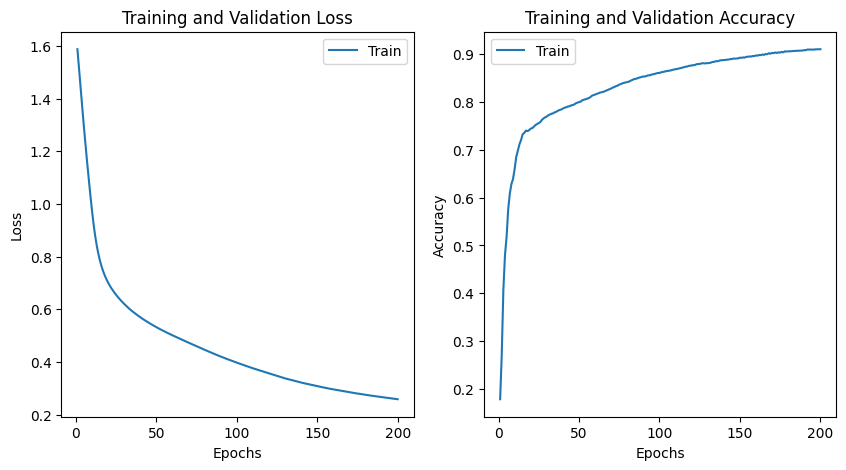

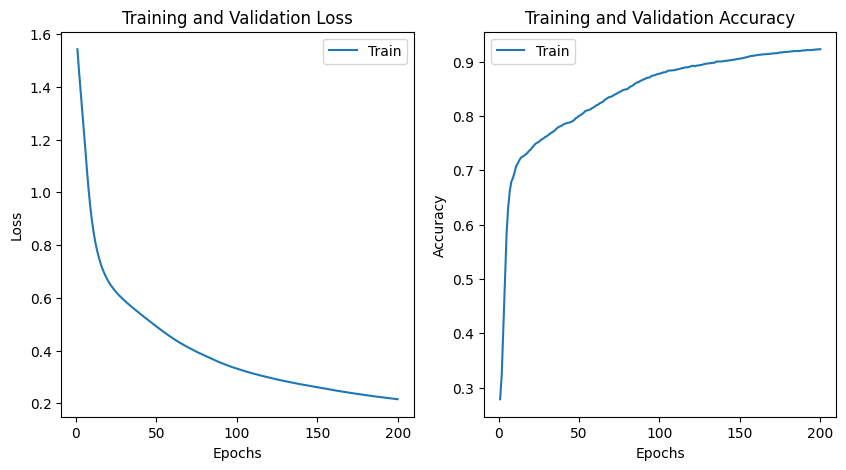

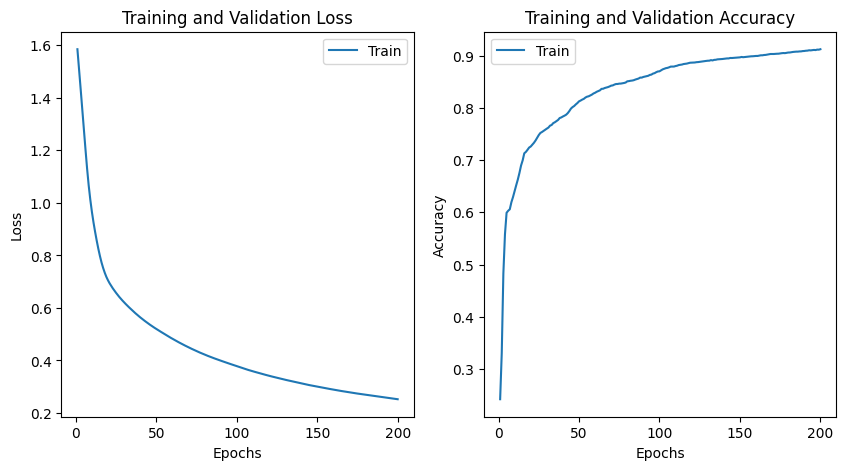

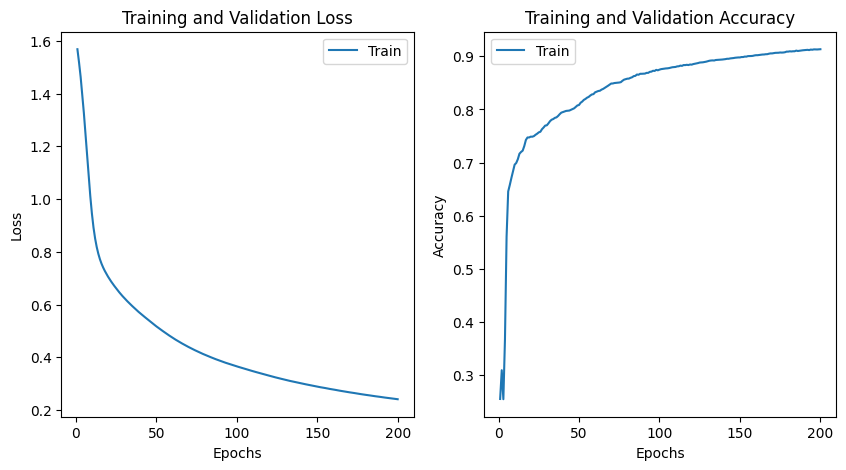

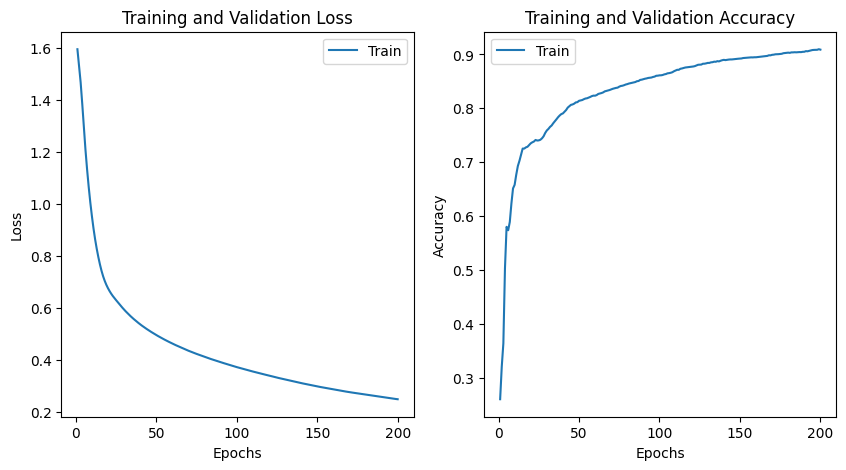

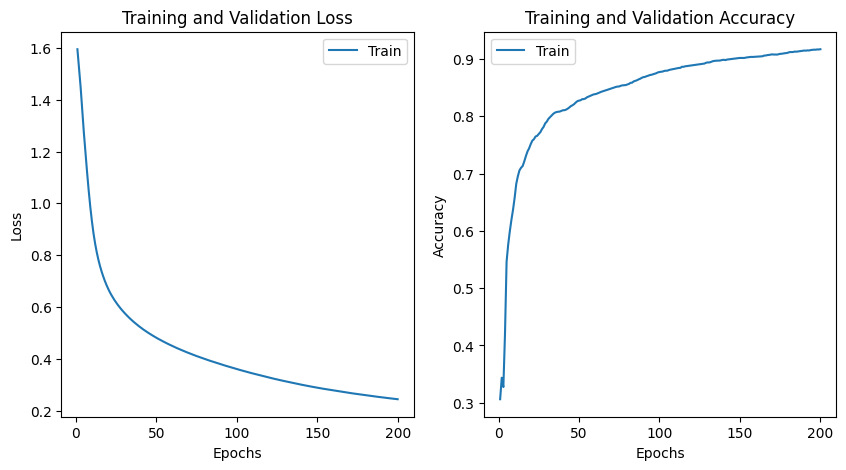

EVERYTHING COMPLETED SUCCESSFULLY


In [36]:
train_experts(6)

In [40]:
def winnow(no_of_experts):
    experts=[]
    weights=[]
    balance=[]
    for i in range(no_of_experts):
        model=torch.load("no_noise_expert_"+str(i+1)+".pt")
        model.eval()
        experts.append(model)
        weights.append(1)
        balance.append(0)
    increase_count=0
    reduce_count=0
    # winnow majority on all of datasets
    train_loader=customDS_train.generate_batches_with_labels(0,len(df_train))
    for inputs,labels in tqdm(train_loader):
#         print(inputs.shape)
        for i in range(len(inputs)):
            predictions=[-99999,-99999,-99999,-99999,-99999]
            dict_of_predictions={0:[],1:[],2:[],3:[],4:[]}
            
            # Gathering Predictions
            for j in range(len(experts)):
                model=experts[j]
                input_copy = inputs[i].unsqueeze(0).clone()
                output=model(input_copy.to(device).to(torch.float32))
                _, predicted = torch.max(output, 1)
                predicted=int(predicted)
                predictions[predicted]=max(predictions[predicted],balance[j])
                dict_of_predictions[predicted].append(j)

            result_pred=predictions.index(max(predictions))
            correct_result=int(labels[i])
            # reducing/increasing weights only if prediction wrong
            if result_pred!=correct_result:
                # increasing Correct weights by 2
                for w in dict_of_predictions[correct_result]:
                    weights[w]=weights[w]*2
                    balance[w]+=1
                    increase_count+=1
                    
                # decreasing incorrect weights by 2
                for incorr_label in range(5):
                    if incorr_label!=correct_result:
                        for w in dict_of_predictions[incorr_label]:
                                weights[w]=weights[w]/2
                                balance[w]-=1
                                reduce_count+=1
        print("After Batch",weights)
        print("After Batch balance",balance)
        print("increased",increase_count,"Reduced",reduce_count)
    with open('weights_no_noise.pkl', 'wb') as f:
        pickle.dump(weights, f)
    return weights

In [42]:
weights=winnow(6)

  2%|▏         | 1/61 [00:02<02:03,  2.06s/it]

After Batch [0.001953125, 2.0, 0.03125, 0.5, 0.125, 0.125]
After Batch balance [-9, 1, -5, -1, -3, -3]
increased 437 Reduced 457


  3%|▎         | 2/61 [00:04<02:00,  2.05s/it]

After Batch [7.62939453125e-06, 2.0, 0.5, 0.125, 0.001953125, 0.5]
After Batch balance [-17, 1, -1, -3, -9, -1]
increased 714 Reduced 744


  5%|▍         | 3/61 [00:06<01:59,  2.05s/it]

After Batch [7.450580596923828e-09, 0.5, 0.001953125, 0.001953125, 2.9802322387695312e-08, 0.0078125]
After Batch balance [-27, -1, -9, -9, -25, -7]
increased 1080 Reduced 1158


  7%|▋         | 4/61 [00:08<01:59,  2.10s/it]

After Batch [1.862645149230957e-09, 2.0, 0.0001220703125, 0.0078125, 7.450580596923828e-09, 0.125]
After Batch balance [-29, 1, -13, -7, -27, -3]
increased 1404 Reduced 1482


  8%|▊         | 5/61 [00:10<01:57,  2.09s/it]

After Batch [4.656612873077393e-10, 2.0, 1.9073486328125e-06, 0.00048828125, 4.656612873077393e-10, 2.0]
After Batch balance [-31, 1, -19, -11, -31, 1]
increased 1692 Reduced 1782


 10%|▉         | 6/61 [00:12<01:54,  2.08s/it]

After Batch [2.9103830456733704e-11, 2.0, 7.62939453125e-06, 0.125, 1.1368683772161603e-13, 0.125]
After Batch balance [-35, 1, -17, -3, -43, -3]
increased 2005 Reduced 2105


 11%|█▏        | 7/61 [00:14<01:52,  2.09s/it]

After Batch [4.547473508864641e-13, 0.5, 3.0517578125e-05, 2.0, 1.1368683772161603e-13, 2.0]
After Batch balance [-41, -1, -15, 1, -43, 1]
increased 2372 Reduced 2470


 13%|█▎        | 8/61 [00:16<01:50,  2.09s/it]

After Batch [7.105427357601002e-15, 2.0, 4.656612873077393e-10, 7.62939453125e-06, 1.1368683772161603e-13, 2.0]
After Batch balance [-47, 1, -31, -17, -43, 1]
increased 2689 Reduced 2825


 15%|█▍        | 9/61 [00:18<01:49,  2.10s/it]

After Batch [1.1368683772161603e-13, 2.0, 4.656612873077393e-10, 0.00048828125, 7.450580596923828e-09, 2.0]
After Batch balance [-43, 1, -31, -11, -27, 1]
increased 3098 Reduced 3208


 16%|█▋        | 10/61 [00:20<01:47,  2.11s/it]

After Batch [5.551115123125783e-17, 1.0, 1.4901161193847656e-08, 0.015625, 9.313225746154785e-10, 1.0]
After Batch balance [-54, 0, -26, -6, -30, 0]
increased 3500 Reduced 3616


 18%|█▊        | 11/61 [00:23<01:45,  2.11s/it]

After Batch [2.7755575615628914e-17, 2.0, 3.0517578125e-05, 0.5, 1.8189894035458565e-12, 2.0]
After Batch balance [-55, 1, -15, -1, -39, 1]
increased 3831 Reduced 3939


 20%|█▉        | 12/61 [00:25<01:42,  2.10s/it]

After Batch [4.336808689942018e-19, 2.0, 4.76837158203125e-07, 0.00048828125, 2.842170943040401e-14, 2.0]
After Batch balance [-61, 1, -21, -11, -45, 1]
increased 4093 Reduced 4229


 21%|██▏       | 13/61 [00:27<01:41,  2.11s/it]

After Batch [1.6940658945086007e-21, 2.0, 7.450580596923828e-09, 7.62939453125e-06, 4.440892098500626e-16, 2.0]
After Batch balance [-69, 1, -27, -17, -51, 1]
increased 4452 Reduced 4614


 23%|██▎       | 14/61 [00:29<01:38,  2.09s/it]

After Batch [1.6940658945086007e-21, 2.0, 4.656612873077393e-10, 0.03125, 6.938893903907228e-18, 2.0]
After Batch balance [-69, 1, -31, -5, -57, 1]
increased 4789 Reduced 4949


 25%|██▍       | 15/61 [00:31<01:35,  2.08s/it]

After Batch [8.470329472543003e-22, 4.0, 1.4901161193847656e-08, 1.0, 5.421010862427522e-20, 0.25]
After Batch balance [-70, 2, -26, 0, -64, -2]
increased 5026 Reduced 5186


 26%|██▌       | 16/61 [00:33<01:34,  2.10s/it]

After Batch [1.0339757656912846e-25, 2.0, 4.656612873077393e-10, 7.62939453125e-06, 1.0842021724855044e-19, 2.0]
After Batch balance [-83, 1, -31, -17, -63, 1]
increased 5415 Reduced 5607


 28%|██▊       | 17/61 [00:35<01:32,  2.10s/it]

After Batch [6.617444900424222e-24, 0.125, 1.8189894035458565e-12, 1.9073486328125e-06, 1.1102230246251565e-16, 2.0]
After Batch balance [-77, -3, -39, -19, -53, 1]
increased 5842 Reduced 6032


 30%|██▉       | 18/61 [00:37<01:29,  2.09s/it]

After Batch [1.6543612251060553e-24, 0.5, 1.8189894035458565e-12, 0.03125, 7.105427357601002e-15, 0.125]
After Batch balance [-79, -1, -39, -5, -47, -3]
increased 6180 Reduced 6354


 31%|███       | 19/61 [00:39<01:28,  2.11s/it]

After Batch [1.0339757656912846e-25, 0.5, 1.9073486328125e-06, 0.5, 1.1102230246251565e-16, 2.0]
After Batch balance [-83, -1, -19, -1, -53, 1]
increased 6531 Reduced 6687


 33%|███▎      | 20/61 [00:41<01:26,  2.10s/it]

After Batch [6.310887241768095e-30, 2.0, 1.862645149230957e-09, 0.0001220703125, 2.710505431213761e-20, 0.125]
After Batch balance [-97, 1, -29, -13, -65, -3]
increased 6866 Reduced 7072


 34%|███▍      | 21/61 [00:43<01:23,  2.09s/it]

After Batch [1.0097419586828951e-28, 2.0, 1.862645149230957e-09, 0.125, 1.6940658945086007e-21, 2.0]
After Batch balance [-93, 1, -29, -3, -69, 1]
increased 7173 Reduced 7365


 36%|███▌      | 22/61 [00:46<01:21,  2.09s/it]

After Batch [3.944304526105059e-31, 2.0, 2.9103830456733704e-11, 0.0001220703125, 1.0587911840678754e-22, 0.125]
After Batch balance [-101, 1, -35, -13, -73, -3]
increased 7451 Reduced 7675


 38%|███▊      | 23/61 [00:48<01:20,  2.11s/it]

After Batch [6.162975822039155e-33, 2.0, 4.656612873077393e-10, 0.5, 4.1359030627651384e-25, 2.0]
After Batch balance [-107, 1, -31, -1, -81, 1]
increased 7808 Reduced 8026


 39%|███▉      | 24/61 [00:50<01:17,  2.09s/it]

After Batch [1.5407439555097887e-33, 2.0, 1.862645149230957e-09, 2.0, 4.1359030627651384e-25, 2.0]
After Batch balance [-109, 1, -29, 1, -81, 1]
increased 8127 Reduced 8343


 41%|████      | 25/61 [00:52<01:15,  2.09s/it]

After Batch [2.407412430484045e-35, 2.0, 7.105427357601002e-15, 7.62939453125e-06, 1.0339757656912846e-25, 0.5]
After Batch balance [-115, 1, -47, -17, -83, -1]
increased 8410 Reduced 8672


 43%|████▎     | 26/61 [00:54<01:13,  2.10s/it]

After Batch [1.2037062152420224e-35, 1.0, 5.684341886080802e-14, 0.00390625, 1.3552527156068805e-20, 1.0]
After Batch balance [-116, 0, -44, -8, -66, 0]
increased 8925 Reduced 9159


 44%|████▍     | 27/61 [00:56<01:11,  2.10s/it]

After Batch [1.504632769052528e-36, 2.0, 4.547473508864641e-13, 0.125, 4.235164736271502e-22, 0.5]
After Batch balance [-119, 1, -41, -3, -71, -1]
increased 9270 Reduced 9504


 46%|████▌     | 28/61 [00:58<01:09,  2.09s/it]

After Batch [2.350988701644575e-38, 2.0, 4.656612873077393e-10, 0.5, 4.1359030627651384e-25, 2.0]
After Batch balance [-125, 1, -31, -1, -81, 1]
increased 9569 Reduced 9805


 48%|████▊     | 29/61 [01:00<01:06,  2.08s/it]

After Batch [2.2958874039497803e-41, 2.0, 1.1641532182693481e-10, 0.00048828125, 6.462348535570529e-27, 2.0]
After Batch balance [-135, 1, -33, -11, -87, 1]
increased 9891 Reduced 10155


 49%|████▉     | 30/61 [01:02<01:04,  2.08s/it]

After Batch [9.183549615799121e-41, 2.0, 1.1368683772161603e-13, 0.00048828125, 4.0389678347315804e-28, 2.0]
After Batch balance [-133, 1, -43, -11, -91, 1]
increased 10233 Reduced 10509


 51%|█████     | 31/61 [01:04<01:02,  2.09s/it]

After Batch [5.739718509874451e-42, 2.0, 7.105427357601002e-15, 0.03125, 6.310887241768095e-30, 2.0]
After Batch balance [-137, 1, -47, -5, -97, 1]
increased 10499 Reduced 10783


 52%|█████▏    | 32/61 [01:07<01:01,  2.10s/it]

After Batch [2.2420775429197073e-44, 0.0078125, 4.547473508864641e-13, 0.03125, 6.162975822039155e-33, 0.125]
After Batch balance [-145, -7, -41, -5, -107, -3]
increased 10835 Reduced 11143


 54%|█████▍    | 33/61 [01:09<00:58,  2.10s/it]

After Batch [7.006492321624085e-46, 1.0, 1.3877787807814457e-17, 3.814697265625e-06, 4.930380657631324e-32, 1.0]
After Batch balance [-150, 0, -56, -18, -104, 0]
increased 11218 Reduced 11546


 56%|█████▌    | 34/61 [01:11<00:57,  2.12s/it]

After Batch [5.605193857299268e-45, 2.0, 2.7755575615628914e-17, 0.0001220703125, 6.462348535570529e-27, 2.0]
After Batch balance [-147, 1, -55, -13, -87, 1]
increased 11607 Reduced 11907


 57%|█████▋    | 35/61 [01:13<00:54,  2.11s/it]

After Batch [3.503246160812043e-46, 0.5, 7.105427357601002e-15, 0.03125, 6.462348535570529e-27, 2.0]
After Batch balance [-151, -1, -47, -5, -87, 1]
increased 11990 Reduced 12280


 59%|█████▉    | 36/61 [01:15<00:52,  2.10s/it]

After Batch [5.473822126268817e-48, 2.0, 1.8189894035458565e-12, 2.0, 6.310887241768095e-30, 2.0]
After Batch balance [-157, 1, -39, 1, -97, 1]
increased 12338 Reduced 12628


 61%|██████    | 37/61 [01:17<00:50,  2.11s/it]

After Batch [8.552847072295026e-50, 2.0, 2.842170943040401e-14, 0.00048828125, 2.465190328815662e-32, 2.0]
After Batch balance [-163, 1, -45, -11, -105, 1]
increased 12622 Reduced 12944


 62%|██████▏   | 38/61 [01:19<00:48,  2.10s/it]

After Batch [1.7105694144590052e-49, 1.0, 5.684341886080802e-14, 0.0625, 7.703719777548943e-34, 0.25]
After Batch balance [-162, 0, -44, -4, -110, -2]
increased 12925 Reduced 13247


 64%|██████▍   | 39/61 [01:21<00:46,  2.09s/it]

After Batch [2.088097429759528e-53, 0.5, 1.1102230246251565e-16, 0.00048828125, 2.407412430484045e-35, 2.0]
After Batch balance [-175, -1, -53, -11, -115, 1]
increased 13272 Reduced 13626


 66%|██████▌   | 40/61 [01:23<00:44,  2.11s/it]

After Batch [8.352389719038111e-53, 2.0, 1.7763568394002505e-15, 2.0, 9.4039548065783e-38, 0.5]
After Batch balance [-173, 1, -49, 1, -123, -1]
increased 13565 Reduced 13909


 67%|██████▋   | 41/61 [01:25<00:42,  2.10s/it]

After Batch [5.22024357439882e-54, 2.0, 1.7763568394002505e-15, 0.03125, 9.4039548065783e-38, 0.5]
After Batch balance [-177, 1, -49, -5, -123, -1]
increased 13878 Reduced 14232


 69%|██████▉   | 42/61 [01:28<00:40,  2.12s/it]

After Batch [2.5489470578119236e-57, 1.0, 8.673617379884035e-19, 1.52587890625e-05, 4.81482486096809e-35, 1.0]
After Batch balance [-188, 0, -60, -16, -114, 0]
increased 14313 Reduced 14691


 70%|███████   | 43/61 [01:30<00:38,  2.12s/it]

After Batch [1.305060893599705e-54, 2.0, 4.336808689942018e-19, 0.125, 2.465190328815662e-32, 0.5]
After Batch balance [-179, 1, -61, -3, -105, -1]
increased 14715 Reduced 15063


 72%|███████▏  | 44/61 [01:32<00:36,  2.12s/it]

After Batch [1.0195788231247695e-56, 1.0, 1.3877787807814457e-17, 0.25, 1.925929944387236e-34, 1.0]
After Batch balance [-186, 0, -56, -2, -112, 0]
increased 14996 Reduced 15352


 74%|███████▍  | 45/61 [01:34<00:33,  2.11s/it]

After Batch [7.778769097326427e-62, 2.0, 4.440892098500626e-16, 3.0517578125e-05, 9.4039548065783e-38, 2.0]
After Batch balance [-203, 1, -51, -15, -123, 1]
increased 15366 Reduced 15756


 75%|███████▌  | 46/61 [01:36<00:31,  2.11s/it]

After Batch [9.956824444577827e-60, 4.0, 2.220446049250313e-16, 0.0625, 2.938735877055719e-39, 1.0]
After Batch balance [-196, 2, -52, -4, -128, 0]
increased 15711 Reduced 16089


 77%|███████▋  | 47/61 [01:38<00:29,  2.11s/it]

After Batch [6.223015277861142e-61, 4.0, 3.469446951953614e-18, 0.0009765625, 7.346839692639297e-40, 1.0]
After Batch balance [-200, 2, -58, -10, -130, 0]
increased 15966 Reduced 16362


 79%|███████▊  | 48/61 [01:40<00:27,  2.12s/it]

After Batch [9.723461371658034e-63, 1.0, 5.551115123125783e-17, 1.0, 7.174648137343064e-43, 1.0]
After Batch balance [-206, 0, -54, 0, -140, 0]
increased 16324 Reduced 16724


 80%|████████  | 49/61 [01:42<00:25,  2.13s/it]

After Batch [3.0385816786431356e-64, 0.5, 2.7755575615628914e-17, 2.0, 8.96831017167883e-44, 2.0]
After Batch balance [-211, -1, -55, 1, -143, 1]
increased 16647 Reduced 17055


 82%|████████▏ | 50/61 [01:45<00:23,  2.13s/it]

After Batch [4.7477838728798994e-66, 2.0, 4.235164736271502e-22, 7.62939453125e-06, 8.96831017167883e-44, 2.0]
After Batch balance [-217, 1, -71, -17, -143, 1]
increased 16940 Reduced 17386


 84%|████████▎ | 51/61 [01:47<00:21,  2.15s/it]

After Batch [3.0385816786431356e-64, 0.5, 2.710505431213761e-20, 0.0078125, 9.4039548065783e-38, 2.0]
After Batch balance [-211, -1, -65, -7, -123, 1]
increased 17422 Reduced 17828


 85%|████████▌ | 52/61 [01:49<00:19,  2.15s/it]

After Batch [2.967364920549937e-67, 2.0, 6.776263578034403e-21, 0.125, 3.6734198463196485e-40, 0.125]
After Batch balance [-221, 1, -67, -3, -131, -3]
increased 17779 Reduced 18203


 87%|████████▋ | 53/61 [01:51<00:17,  2.14s/it]

After Batch [1.8546030753437107e-68, 2.0, 2.7755575615628914e-17, 0.5, 1.4349296274686127e-42, 2.0]
After Batch balance [-225, 1, -55, -1, -139, 1]
increased 18076 Reduced 18494


 89%|████████▊ | 54/61 [01:53<00:14,  2.13s/it]

After Batch [4.636507688359277e-69, 0.5, 2.7755575615628914e-17, 0.00048828125, 8.96831017167883e-44, 2.0]
After Batch balance [-227, -1, -55, -11, -143, 1]
increased 18385 Reduced 18821


 90%|█████████ | 55/61 [01:55<00:12,  2.12s/it]

After Batch [2.263919769706678e-72, 1.0, 1.3552527156068805e-20, 1.52587890625e-05, 7.006492321624085e-46, 1.0]
After Batch balance [-238, 0, -66, -16, -150, 0]
increased 18731 Reduced 19201


 92%|█████████▏| 56/61 [01:57<00:10,  2.13s/it]

After Batch [1.131959884853339e-72, 2.0, 4.235164736271502e-22, 0.03125, 5.473822126268817e-48, 2.0]
After Batch balance [-239, 1, -71, -5, -157, 1]
increased 19040 Reduced 19510


 93%|█████████▎| 57/61 [02:00<00:08,  2.12s/it]

After Batch [4.527839539413356e-72, 2.0, 1.0842021724855044e-19, 2.0, 8.552847072295026e-50, 0.5]
After Batch balance [-237, 1, -63, 1, -163, -1]
increased 19314 Reduced 19776


 95%|█████████▌| 58/61 [02:02<00:06,  2.12s/it]

After Batch [6.908934844075556e-77, 2.0, 2.6469779601696886e-23, 7.62939453125e-06, 8.552847072295026e-50, 2.0]
After Batch balance [-253, 1, -75, -17, -163, 1]
increased 19718 Reduced 20224


 97%|█████████▋| 59/61 [02:04<00:04,  2.12s/it]

After Batch [4.421718300208356e-75, 2.0, 2.6469779601696886e-23, 3.0517578125e-05, 1.401298464324817e-45, 2.0]
After Batch balance [-247, 1, -75, -15, -149, 1]
increased 20125 Reduced 20609


 98%|█████████▊| 60/61 [02:06<00:02,  2.11s/it]

After Batch [4.421718300208356e-75, 2.0, 6.617444900424222e-24, 0.125, 2.2420775429197073e-44, 0.5]
After Batch balance [-247, 1, -77, -3, -145, -1]
increased 20455 Reduced 20927


100%|██████████| 61/61 [02:08<00:00,  2.11s/it]

After Batch [1.0795210693868056e-78, 0.03125, 2.710505431213761e-20, 0.125, 5.473822126268817e-48, 0.5]
After Batch balance [-259, -5, -65, -3, -157, -1]
increased 20788 Reduced 21278


In [67]:
def weighted_majority(no_of_experts):
    experts=[]
    weights=[]
    balance=[]
    for i in range(no_of_experts):
        model=torch.load("no_noise_expert_"+str(i+1)+".pt")
        model.eval()
        experts.append(model)
        weights.append(1)
        balance.append(0)
    increase_count=0
    reduce_count=0
    # winnow majority on all of datasets
    train_loader=customDS_train.generate_batches_with_labels(0,len(df_train))
    for inputs,labels in tqdm(train_loader):
#         print(inputs.shape)
        for i in range(len(inputs)):
            predictions=[-99999,-99999,-99999,-99999,-99999]
            dict_of_predictions={0:[],1:[],2:[],3:[],4:[]}
            
            # Gathering Predictions
            for j in range(len(experts)):
                model=experts[j]
                input_copy = inputs[i].unsqueeze(0).clone()
                output=model(input_copy.to(device).to(torch.float32))
                _, predicted = torch.max(output, 1)
                predicted=int(predicted)
                predictions[predicted]=max(predictions[predicted],balance[j])
                dict_of_predictions[predicted].append(j)

            result_pred=predictions.index(max(predictions))
            correct_result=int(labels[i])
            # reducing/increasing weights only if prediction wrong
            if result_pred!=correct_result:
                # increasing Correct weights by 2
#                 for w in dict_of_predictions[correct_result]:
#                     weights[w]=weights[w]*2
#                     balance[w]+=1
#                     increase_count+=1
                    
                # decreasing incorrect weights by 2
                for incorr_label in range(5):
                    if incorr_label!=correct_result:
                        for w in dict_of_predictions[incorr_label]:
                                weights[w]=weights[w]/2
                                balance[w]-=1
                                reduce_count+=1
        print("After Batch",weights)
        print("After Batch balance",balance)
        print("increased",increase_count,"Reduced",reduce_count)
    with open('weighted_majority_in_power_no_noise.pkl', 'wb') as f:
        pickle.dump(balance, f)
    return weights

In [70]:
weighted_majority(6)

  2%|▏         | 1/61 [00:02<02:06,  2.11s/it]

After Batch [6.617444900424222e-24, 1.0587911840678754e-22, 2.6469779601696886e-23, 5.293955920339377e-23, 2.6469779601696886e-23, 5.293955920339377e-23]
After Batch balance [-77, -73, -75, -74, -75, -74]
increased 0 Reduced 448


  3%|▎         | 2/61 [00:04<02:04,  2.12s/it]

After Batch [1.88079096131566e-37, 1.504632769052528e-36, 7.52316384526264e-37, 7.52316384526264e-37, 3.76158192263132e-37, 1.504632769052528e-36]
After Batch balance [-122, -119, -120, -120, -121, -119]
increased 0 Reduced 721


  5%|▍         | 3/61 [00:06<02:03,  2.14s/it]

After Batch [1.0195788231247695e-56, 4.078315292499078e-56, 2.039157646249539e-56, 1.0195788231247695e-56, 3.1861838222649046e-58, 1.0195788231247695e-56]
After Batch balance [-186, -184, -185, -186, -191, -186]
increased 0 Reduced 1118


  7%|▋         | 4/61 [00:08<02:01,  2.14s/it]

After Batch [8.843436600416711e-75, 1.7686873200833423e-74, 8.843436600416711e-75, 2.210859150104178e-75, 6.908934844075556e-77, 1.7686873200833423e-74]
After Batch balance [-246, -245, -246, -248, -253, -245]
increased 0 Reduced 1483


  8%|▊         | 5/61 [00:10<02:01,  2.17s/it]

After Batch [1.5709099088952725e-89, 1.5709099088952725e-89, 1.5709099088952725e-89, 1.5709099088952725e-89, 1.2272733663244316e-91, 1.5709099088952725e-89]
After Batch balance [-295, -295, -295, -295, -302, -295]
increased 0 Reduced 1777


 10%|▉         | 6/61 [00:12<01:58,  2.16s/it]

After Batch [4.3601508761683463e-106, 4.3601508761683463e-106, 1.7440603504673385e-105, 8.720301752336693e-106, 1.7031839360032603e-108, 1.7440603504673385e-105]
After Batch balance [-350, -350, -348, -349, -358, -348]
increased 0 Reduced 2103


 11%|█▏        | 7/61 [00:15<01:57,  2.17s/it]

After Batch [3.7818280418450374e-124, 7.563656083690075e-124, 3.7818280418450374e-124, 7.563656083690075e-124, 3.6931914471142943e-127, 7.563656083690075e-124]
After Batch balance [-410, -409, -410, -409, -420, -409]
increased 0 Reduced 2467


 13%|█▎        | 8/61 [00:17<01:55,  2.17s/it]

After Batch [1.312085177259197e-141, 2.624170354518394e-141, 3.2802129431479926e-142, 3.2802129431479926e-142, 2.5626663618343692e-144, 2.624170354518394e-141]
After Batch balance [-468, -467, -470, -470, -477, -467]
increased 0 Reduced 2819


 15%|█▍        | 9/61 [00:19<01:52,  2.16s/it]

After Batch [3.556413999176124e-161, 3.556413999176124e-161, 8.89103499794031e-162, 3.556413999176124e-161, 4.445517498970155e-162, 3.556413999176124e-161]
After Batch balance [-533, -533, -535, -533, -536, -533]
increased 0 Reduced 3203


 16%|█▋        | 10/61 [00:21<01:50,  2.16s/it]

After Batch [3.012399831378605e-182, 2.409919865102884e-181, 1.204959932551442e-181, 6.02479966275721e-182, 7.530999578446513e-183, 2.409919865102884e-181]
After Batch balance [-603, -600, -601, -602, -605, -600]
increased 0 Reduced 3611


 18%|█▊        | 11/61 [00:23<01:47,  2.15s/it]

After Batch [6.688871304346933e-198, 1.3377742608693866e-197, 1.3377742608693866e-197, 1.3377742608693866e-197, 2.612840353260521e-200, 1.3377742608693866e-197]
After Batch balance [-655, -654, -654, -654, -663, -654]
increased 0 Reduced 3934


 20%|█▉        | 12/61 [00:25<01:45,  2.16s/it]

After Batch [1.4852277861680936e-213, 2.9704555723361872e-213, 1.4852277861680936e-213, 1.856534732710117e-214, 7.252088799648895e-217, 2.9704555723361872e-213]
After Batch balance [-707, -706, -707, -710, -718, -706]
increased 0 Reduced 4254


 21%|██▏       | 13/61 [00:27<01:43,  2.15s/it]

After Batch [4.0257179809982083e-233, 8.051435961996417e-233, 4.0257179809982083e-233, 1.0064294952495521e-233, 1.9656826079092814e-236, 8.051435961996417e-233]
After Batch balance [-772, -771, -772, -774, -783, -771]
increased 0 Reduced 4643


 23%|██▎       | 14/61 [00:30<01:41,  2.15s/it]

After Batch [3.491753744649773e-251, 6.983507489299546e-251, 3.491753744649773e-251, 1.3967014978599092e-250, 8.52478941564886e-255, 1.3967014978599092e-250]
After Batch balance [-832, -831, -832, -830, -844, -830]
increased 0 Reduced 4999


 25%|██▍       | 15/61 [00:32<01:38,  2.14s/it]

After Batch [2.5405852245238005e-262, 2.0324681796190404e-261, 5.081170449047601e-262, 1.0162340898095202e-261, 1.550650161452515e-266, 5.081170449047601e-262]
After Batch balance [-869, -866, -868, -867, -883, -868]
increased 0 Reduced 5221


 26%|██▌       | 16/61 [00:34<01:36,  2.14s/it]

After Batch [4.303918780958246e-283, 8.607837561916492e-283, 4.303918780958246e-283, 1.0759796952395615e-283, 5.253807105661922e-287, 8.607837561916492e-283]
After Batch balance [-938, -937, -938, -940, -951, -937]
increased 0 Reduced 5641


 28%|██▊       | 17/61 [00:36<01:34,  2.15s/it]

After Batch [3.645561009778199e-304, 1.8227805048890994e-304, 9.113902524445497e-305, 2.2784756311113742e-305, 7.120236347223045e-307, 1.8227805048890994e-304]
After Batch balance [-1008, -1009, -1010, -1012, -1017, -1009]
increased 0 Reduced 6065


 30%|██▉       | 18/61 [00:38<01:32,  2.14s/it]

After Batch [2.53e-321, 2.0237e-320, 1.012e-320, 1.012e-320, 4e-323, 2.0237e-320]
After Batch balance [-1065, -1062, -1063, -1063, -1071, -1062]
increased 0 Reduced 6386


 31%|███       | 19/61 [00:40<01:29,  2.13s/it]

After Batch [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After Batch balance [-1116, -1115, -1114, -1115, -1126, -1114]
increased 0 Reduced 6700


 33%|███▎      | 20/61 [00:43<01:28,  2.17s/it]

After Batch [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After Batch balance [-1183, -1182, -1183, -1186, -1196, -1182]
increased 0 Reduced 7112


 34%|███▍      | 21/61 [00:45<01:26,  2.17s/it]

After Batch [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After Batch balance [-1237, -1237, -1239, -1239, -1254, -1238]
increased 0 Reduced 7444


 36%|███▌      | 22/61 [00:47<01:24,  2.16s/it]

After Batch [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After Batch balance [-1289, -1288, -1289, -1289, -1305, -1291]
increased 0 Reduced 7751


 38%|███▊      | 23/61 [00:49<01:22,  2.16s/it]

After Batch [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After Batch balance [-1350, -1346, -1347, -1348, -1366, -1346]
increased 0 Reduced 8103


 39%|███▉      | 24/61 [00:51<01:19,  2.15s/it]

After Batch [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After Batch balance [-1402, -1400, -1401, -1400, -1419, -1400]
increased 0 Reduced 8422


 41%|████      | 25/61 [00:53<01:17,  2.16s/it]

After Batch [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After Batch balance [-1454, -1453, -1456, -1456, -1471, -1454]
increased 0 Reduced 8744


 43%|████▎     | 26/61 [00:56<01:15,  2.15s/it]

After Batch [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After Batch balance [-1539, -1536, -1537, -1537, -1549, -1536]
increased 0 Reduced 9234


 44%|████▍     | 27/61 [00:58<01:12,  2.14s/it]

After Batch [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After Batch balance [-1594, -1592, -1593, -1593, -1605, -1592]
increased 0 Reduced 9569


 46%|████▌     | 28/61 [01:00<01:10,  2.14s/it]

After Batch [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After Batch balance [-1646, -1644, -1645, -1646, -1662, -1644]
increased 0 Reduced 9887


 48%|████▊     | 29/61 [01:02<01:08,  2.13s/it]

After Batch [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After Batch balance [-1706, -1705, -1705, -1710, -1726, -1704]
increased 0 Reduced 10256


 49%|████▉     | 30/61 [01:04<01:05,  2.13s/it]

After Batch [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After Batch balance [-1767, -1767, -1767, -1767, -1786, -1767]
increased 0 Reduced 10621


 51%|█████     | 31/61 [01:06<01:03,  2.13s/it]

After Batch [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After Batch balance [-1817, -1815, -1816, -1815, -1836, -1815]
increased 0 Reduced 10914


 52%|█████▏    | 32/61 [01:08<01:01,  2.13s/it]

After Batch [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After Batch balance [-1871, -1871, -1871, -1871, -1893, -1870]
increased 0 Reduced 11247


 54%|█████▍    | 33/61 [01:10<00:59,  2.13s/it]

After Batch [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After Batch balance [-1939, -1938, -1941, -1941, -1960, -1938]
increased 0 Reduced 11657


 56%|█████▌    | 34/61 [01:13<00:57,  2.15s/it]

After Batch [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After Batch balance [-2001, -2000, -2002, -2001, -2015, -2000]
increased 0 Reduced 12019


 57%|█████▋    | 35/61 [01:15<00:55,  2.15s/it]

After Batch [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After Batch balance [-2067, -2063, -2063, -2065, -2080, -2063]
increased 0 Reduced 12401


 59%|█████▉    | 36/61 [01:17<00:53,  2.14s/it]

After Batch [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After Batch balance [-2119, -2117, -2118, -2117, -2138, -2117]
increased 0 Reduced 12726


 61%|██████    | 37/61 [01:19<00:51,  2.13s/it]

After Batch [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After Batch balance [-2177, -2176, -2177, -2180, -2200, -2176]
increased 0 Reduced 13086


 62%|██████▏   | 38/61 [01:21<00:49,  2.13s/it]

After Batch [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After Batch balance [-2229, -2229, -2230, -2230, -2254, -2230]
increased 0 Reduced 13402


 64%|██████▍   | 39/61 [01:23<00:46,  2.13s/it]

After Batch [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After Batch balance [-2296, -2293, -2294, -2294, -2318, -2293]
increased 0 Reduced 13788


 66%|██████▌   | 40/61 [01:25<00:44,  2.14s/it]

After Batch [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After Batch balance [-2341, -2338, -2339, -2338, -2366, -2338]
increased 0 Reduced 14060


 67%|██████▋   | 41/61 [01:28<00:43,  2.15s/it]

After Batch [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After Batch balance [-2394, -2392, -2394, -2393, -2420, -2393]
increased 0 Reduced 14386


 69%|██████▉   | 42/61 [01:30<00:40,  2.15s/it]

After Batch [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After Batch balance [-2472, -2470, -2471, -2473, -2491, -2470]
increased 0 Reduced 14847


 70%|███████   | 43/61 [01:32<00:38,  2.14s/it]

After Batch [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After Batch balance [-2535, -2532, -2533, -2533, -2553, -2532]
increased 0 Reduced 15218


 72%|███████▏  | 44/61 [01:34<00:36,  2.15s/it]

After Batch [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After Batch balance [-2580, -2579, -2580, -2579, -2601, -2579]
increased 0 Reduced 15498


 74%|███████▍  | 45/61 [01:36<00:34,  2.16s/it]

After Batch [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After Batch balance [-2650, -2647, -2648, -2652, -2673, -2647]
increased 0 Reduced 15917


 75%|███████▌  | 46/61 [01:38<00:32,  2.15s/it]

After Batch [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After Batch balance [-2709, -2709, -2711, -2711, -2738, -2710]
increased 0 Reduced 16288


 77%|███████▋  | 47/61 [01:40<00:30,  2.15s/it]

After Batch [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After Batch balance [-2755, -2754, -2755, -2756, -2782, -2756]
increased 0 Reduced 16558


 79%|███████▊  | 48/61 [01:43<00:27,  2.14s/it]

After Batch [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After Batch balance [-2817, -2814, -2814, -2815, -2845, -2814]
increased 0 Reduced 16919


 80%|████████  | 49/61 [01:45<00:26,  2.17s/it]

After Batch [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After Batch balance [-2871, -2870, -2871, -2869, -2901, -2869]
increased 0 Reduced 17251


 82%|████████▏ | 50/61 [01:47<00:23,  2.15s/it]

After Batch [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After Batch balance [-2924, -2923, -2926, -2926, -2953, -2923]
increased 0 Reduced 17575


 84%|████████▎ | 51/61 [01:49<00:21,  2.15s/it]

After Batch [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After Batch balance [-3001, -3000, -2999, -2999, -3023, -2999]
increased 0 Reduced 18021


 85%|████████▌ | 52/61 [01:51<00:19,  2.16s/it]

After Batch [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After Batch balance [-3062, -3060, -3061, -3061, -3085, -3060]
increased 0 Reduced 18389


 87%|████████▋ | 53/61 [01:53<00:17,  2.16s/it]

After Batch [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After Batch balance [-3110, -3109, -3109, -3109, -3138, -3109]
increased 0 Reduced 18684


 89%|████████▊ | 54/61 [01:56<00:15,  2.17s/it]

After Batch [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After Batch balance [-3167, -3168, -3166, -3171, -3199, -3167]
increased 0 Reduced 19038


 90%|█████████ | 55/61 [01:58<00:13,  2.18s/it]

After Batch [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After Batch balance [-3233, -3233, -3232, -3235, -3263, -3232]
increased 0 Reduced 19428


 92%|█████████▏| 56/61 [02:00<00:10,  2.17s/it]

After Batch [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After Batch balance [-3289, -3287, -3288, -3287, -3320, -3287]
increased 0 Reduced 19758


 93%|█████████▎| 57/61 [02:02<00:08,  2.18s/it]

After Batch [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After Batch balance [-3329, -3329, -3328, -3329, -3364, -3330]
increased 0 Reduced 20009


 95%|█████████▌| 58/61 [02:04<00:06,  2.17s/it]

After Batch [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After Batch balance [-3404, -3402, -3404, -3405, -3436, -3402]
increased 0 Reduced 20453


 97%|█████████▋| 59/61 [02:06<00:04,  2.18s/it]

After Batch [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After Batch balance [-3468, -3468, -3468, -3470, -3496, -3468]
increased 0 Reduced 20838


 98%|█████████▊| 60/61 [02:09<00:02,  2.17s/it]

After Batch [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After Batch balance [-3523, -3520, -3521, -3521, -3549, -3521]
increased 0 Reduced 21155


100%|██████████| 61/61 [02:11<00:00,  2.15s/it]

After Batch [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After Batch balance [-3577, -3576, -3576, -3576, -3607, -3575]
increased 0 Reduced 21487


[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

# Testing Loop

In [62]:
def test_winnow(no_of_experts,test_loader):
    experts=[]
    for i in range(no_of_experts):
        model=torch.load("no_noise_expert_"+str(i+1)+".pt")
        model.eval()
        experts.append(model)
    with open('weights_no_noise.pkl', 'rb') as f:
        weights = pickle.load(f)
    correct=0
    total=0
    for inputs,labels in tqdm(test_loader):
        for i in range(len(inputs)):
            predictions=[0,0,0,0,0]
            dict_of_predictions={0:[],1:[],2:[],3:[],4:[]}
            # Gathering Predictions
            for j in range(len(experts)):
                model=experts[j]
                input_copy = inputs[i].unsqueeze(0).clone()
                output=model(input_copy.to(device).to(torch.float32))
                _, predicted = torch.max(output, 1)
                predicted=int(predicted)
                predictions[predicted]+=weights[j]
                dict_of_predictions[predicted].append(j)

            result_pred=predictions.index(max(predictions))
            correct_result=int(labels[i])
            # reducing/increasing weights only if prediction wrong
            total+=1
            if result_pred==correct_result:
                correct+=1
    print("Accuracy",correct/total)
    

In [59]:
test_loader=customDS_test.generate_batches_with_labels(0,len(df_test))
test_winnow(6,test_loader)

100%|██████████| 61/61 [02:09<00:00,  2.12s/it]

Accuracy 0.7961378205128206


In [64]:
train_loader=customDS_train.generate_batches_with_labels(0,len(df_train))
test_winnow(6,train_loader)

100%|██████████| 61/61 [02:11<00:00,  2.16s/it]

Accuracy 0.918349358974359


In [15]:
def test_weighted_majority(no_of_experts,test_loader):
    experts=[]
    for i in range(no_of_experts):
        model=torch.load("no_noise_expert_"+str(i+1)+".pt")
        model.eval()
        experts.append(model)
    with open('/kaggle/working/weighted_majority_in_power_no_noise.pkl', 'rb') as f:
        weights = pickle.load(f)
    correct=0
    total=0
    for inputs,labels in tqdm(test_loader):
        for i in range(len(inputs)):
            predictions=[-99999,-99999,-99999,-99999,-99999]
            dict_of_predictions={0:[],1:[],2:[],3:[],4:[]}
            # Gathering Predictions
            for j in range(len(experts)):
                model=experts[j]
                input_copy = inputs[i].unsqueeze(0).clone()
                output=model(input_copy.to(device).to(torch.float32))
                _, predicted = torch.max(output, 1)
                predicted=int(predicted)
                predictions[predicted]=max(weights[j],predictions[predicted])
                dict_of_predictions[predicted].append(j)

            result_pred=predictions.index(max(predictions))
            correct_result=int(labels[i])
            # reducing/increasing weights only if prediction wrong
            total+=1
            if result_pred==correct_result:
                correct+=1
    print("Accuracy",correct/total)

In [10]:
test_loader=customDS_test.generate_batches_with_labels(0,len(df_test))
test_weighted_majority(6,test_loader)

100%|██████████| 61/61 [02:10<00:00,  2.14s/it]

Accuracy 0.7961378205128206


In [17]:
train_loader=customDS_train.generate_batches_with_labels(0,len(df_train))
test_weighted_majority(6,train_loader)

100%|██████████| 61/61 [02:11<00:00,  2.15s/it]

Accuracy 0.918349358974359
